In [1]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from utils import data_processing
from utils.simulations import *
from execute import surv_hivae, surv_gan, surv_vae

import os
import json

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


## Simulate the initial data

In [2]:
n_samples = 600
n_features_bytype = 5
n_active_features = 3
treatment_effect = 0.
surv_type = "surv_weibull"
feature_types_list = ["real", "cat"]

control, treated, types = simulation(treatment_effect, n_samples,
                                     n_features_bytype=n_features_bytype,
                                     n_active_features=n_active_features,
                                     feature_types_list=feature_types_list, 
                                     surv_type=surv_type)
control = control.drop(columns='treatment')
treated = treated.drop(columns='treatment')

In [3]:
control.head()

,0,1,2,3,4,5,6,7,8,9,time,censor
0,0.359455,-1.087861,-0.971395,-0.031761,-0.382501,0.0,0.0,0.0,0.0,1.0,1.538914,1
3,0.402315,0.339079,-0.695970,-0.148623,-0.213195,1.0,1.0,1.0,0.0,0.0,0.992960,1
4,-2.614394,-0.673155,-0.586811,1.407122,1.860992,1.0,1.0,1.0,1.0,1.0,0.641330,1
6,0.037494,0.773368,-0.772999,-0.568304,0.872855,1.0,1.0,1.0,1.0,0.0,1.216093,1
8,1.850944,1.612619,0.735410,0.014733,0.253825,1.0,1.0,0.0,0.0,1.0,0.930639,1


In [4]:
print("percent of uncensored data in control set {:.3f} and in treated set {:.3f}".format(np.mean(control['censor']), 
                                                                                          np.mean(treated['censor'])))

percent of uncensored data in control set 0.929 and in treated set 0.900


## Save data

In [5]:
dataset_name = "Simulations"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
miss_file = "dataset/" + dataset_name + "/Missing.csv"
true_miss_file = None

control.to_csv(data_file_control, index=False, header=False)
types.to_csv(feat_types_file_control)
treated.to_csv(data_file_treated, index=False, header=False)
types.to_csv(feat_types_file_treated)

## Load data

In [6]:
# Load and transform control data
data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, feat_types_file_control, miss_file, true_miss_file)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, miss_file, true_miss_file)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [7]:
fnames = types['name'][:-1].tolist()
fnames.append("time")#.append("censor")
fnames.append("censor")

In [8]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)

# Update dataframe
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

### Hyperparameters optimization

In [9]:
# Parameters of the optuna study
name_config = "simu_N{}_nfeat{}_t{}_{}".format(n_samples, n_features_bytype, treatment_effect, surv_type)
n_trials = 2 # number of trials for each generator
n_splits = 2 # number of splits for cross-validation
n_generated_sample = 50 # number of generated datasets per fold to compute the metric 

In [10]:
# the datasets used for training is data_init_control
T_surv = torch.Tensor(df_init_control.time)
T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
n_intervals = 10
T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]

In [11]:
generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
generators_dict = {"HI-VAE_weibull" : surv_hivae,
                   "HI-VAE_piecewise" : surv_hivae,
                   "Surv-GAN" : surv_gan,
                   "Surv-VAE" : surv_vae}

best_params_dict, study_dict = {}, {}
for generator_name in generators_sel:
    db_file = "optuna_results/optuna_study_{}_{}.db".format(name_config, generator_name)
    if os.path.exists(db_file):
        print("This optuna study already exists. Please change the name of the study or remove the file to create a new one.")
    else: 
        print("Creating new optuna study for {}...".format(generator_name))
        if generator_name in ["HI-VAE_weibull", "HI-VAE_piecewise"]:
            feat_types_dict_ext = feat_types_dict.copy()
            for i in range(len(feat_types_dict)):
                if feat_types_dict_ext[i]['name'] == "survcens":
                    if generator_name in["HI-VAE_weibull"]:
                        feat_types_dict_ext[i]["type"] = 'surv_weibull'
                    else:
                        feat_types_dict_ext[i]["type"] = 'surv_piecewise'
            best_params, study = generators_dict[generator_name].optuna_hyperparameter_search((data_init_control_encoded, intervals), 
                                                                                                data_init_control,
                                                                                                miss_mask_control, 
                                                                                                true_miss_mask_control,
                                                                                                feat_types_dict_ext, 
                                                                                                n_generated_sample=n_generated_sample, 
                                                                                                n_splits=n_splits,
                                                                                                n_trials=n_trials, 
                                                                                                columns=fnames, 
                                                                                                study_name="optuna_results/optuna_study_{}_{}".format(name_config, generator_name),)
            best_params_dict[generator_name] = best_params
            study_dict[generator_name] = study
            with open("optuna_results/best_params_{}_{}.json".format(name_config, generator_name), "w") as f:
                json.dump(best_params, f)
        else: 
            best_params, study = generators_dict[generator_name].optuna_hyperparameter_search(data_init_control, 
                                                                                            columns=fnames, 
                                                                                            target_column="censor", 
                                                                                            time_to_event_column="time", 
                                                                                            n_generated_sample=n_generated_sample, 
                                                                                            n_splits=n_splits,
                                                                                            n_trials=n_trials, 
                                                                                            study_name="optuna_results/optuna_study_{}_{}".format(name_config, generator_name),)
            best_params_dict[generator_name] = best_params
            study_dict[generator_name] = study
            with open("optuna_results/best_params_{}_{}.json".format(name_config, generator_name), "w") as f:
                json.dump(best_params, f)

This optuna study already exists. Please change the name of the study or remove the file to create a new one.
This optuna study already exists. Please change the name of the study or remove the file to create a new one.
This optuna study already exists. Please change the name of the study or remove the file to create a new one.
This optuna study already exists. Please change the name of the study or remove the file to create a new one.


### Run models with best hyperparameters

In [12]:
with open("optuna_results/best_params_{}_{}.json".format(name_config, "HI-VAE_weibull"), "r") as f:
    best_params_hivae_weibull = json.load(f)
with open("optuna_results/best_params_{}_{}.json".format(name_config, "HI-VAE_piecewise"), "r") as f:
    best_params_hivae_piecewise = json.load(f)
with open("optuna_results/best_params_{}_{}.json".format(name_config, "Surv-GAN"), "r") as f:
    best_params_survgan = json.load(f)
with open("optuna_results/best_params_{}_{}.json".format(name_config, "Surv-VAE"), "r") as f:
    best_params_survae = json.load(f)

## 2. Training and generation from the generative model

Possible generative models: HI-VAE (our), survival_gan, survival_ctgan, survival_nflow, survae (synthcity)

### Run with defaut_params

In [13]:
# the datasets used for training is data_init_control
n_generated_dataset = 100
generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
data_gen_control_dict = {}
for generator_name in generators_sel:
    print("=" * 100)
    print("Generate data by " + generator_name)
    if generator_name in ["HI-VAE_weibull", "HI-VAE_piecewise"]:
        feat_types_dict_ext = feat_types_dict.copy()
        for i in range(len(feat_types_dict)):
            if feat_types_dict_ext[i]['name'] == "survcens":
                if generator_name in["HI-VAE_weibull"]:
                    feat_types_dict_ext[i]["type"] = 'surv_weibull'
                else:
                    feat_types_dict_ext[i]["type"] = 'surv_piecewise'
        data_gen_control_dict[generator_name] = generators_dict[generator_name].run((data_init_control_encoded, intervals), miss_mask_control, true_miss_mask_control, feat_types_dict_ext, n_generated_dataset)
    else:
        if generator_name in["Surv-GAN"]:
            best_params = best_params_survgan
        else:
            best_params = best_params_survae
        data_gen_control_dict[generator_name] = generators_dict[generator_name].run(data_init_control, columns=fnames, target_column="censor", time_to_event_column="time", n_generated_sample=n_generated_dataset)

Generate data by HI-VAE_weibull
Epoch: [ 0]  time: 0.0301, ELBO_train: -12.97650290, KL_z: 1.83333004, KL_s: 0.08413136, reconstruction loss: -11.05904150
Epoch: [100]  time: 1.1967, ELBO_train: -10.37372589, KL_z: 0.69166860, KL_s: 0.04541981, reconstruction loss: -9.63663748
Epoch: [200]  time: 2.2853, ELBO_train: -9.98181820, KL_z: 0.86280218, KL_s: 0.03855705, reconstruction loss: -9.08045897
Epoch: [300]  time: 3.4792, ELBO_train: -9.95173359, KL_z: 1.00456718, KL_s: 0.04170287, reconstruction loss: -8.90546355
Epoch: [400]  time: 4.6601, ELBO_train: -9.68843699, KL_z: 1.11273170, KL_s: 0.04387820, reconstruction loss: -8.53182709
Training finished.
Generate data by HI-VAE_piecewise
Epoch: [ 0]  time: 0.0141, ELBO_train: -13.10380554, KL_z: 1.82684469, KL_s: 0.08409178, reconstruction loss: -11.19286907
Epoch: [100]  time: 1.2756, ELBO_train: -10.20832682, KL_z: 0.74260083, KL_s: 0.04277134, reconstruction loss: -9.42295465
Epoch: [200]  time: 2.4272, ELBO_train: -10.02187920, KL_

[2025-05-27T16:49:01.431702+0200][84907][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-27T16:49:02.744367+0200][84907][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


{'fitted': False, 'module_relative_path': Path('../survival_analysis/plugin_survival_gan.py'), 'module_name': 'synthcity.plugins.survival_analysis.plugin_survival_gan', 'class_name': 'SurvivalGANPlugin', 'raw_class': <class 'synthcity.plugins.survival_analysis.plugin_survival_gan.SurvivalGANPlugin'>, '_schema': None, '_training_schema': None, '_data_encoders': None, 'sampling_strategy': 'marginal', 'sampling_patience': 500, 'strict': True, 'device': device(type='cpu'), 'random_state': 0, 'compress_dataset': False, 'workspace': Path('workspace'), 'expecting_conditional': False, 'tte_strategy': 'survival_function', 'dataloader_sampling_strategy': 'imbalanced_time_censoring', 'censoring_strategy': 'random', 'uncensoring_model': 'survival_function_regression', 'use_survival_conditional': True, 'kwargs': {}}


  4%|▍         | 399/10000 [00:13<05:23, 29.64it/s]
[2025-05-27T16:49:20.731846+0200][84907][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-27T16:49:20.744498+0200][84907][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generate data by Surv-VAE


 60%|██████    | 600/1000 [00:29<00:19, 20.44it/s]


In [14]:
generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
data_gen_control_dict_best_params = {}
for generator_name in generators_sel:
    print("=" * 100)
    print("Generate data by " + generator_name)
    if generator_name in ["HI-VAE_weibull", "HI-VAE_piecewise"]:
        feat_types_dict_ext = feat_types_dict.copy()
        for i in range(len(feat_types_dict)):
            if feat_types_dict_ext[i]['name'] == "survcens":
                if generator_name in["HI-VAE_weibull"]:
                    feat_types_dict_ext[i]["type"] = 'surv_weibull'
                    best_params_hivae = best_params_hivae_weibull
                else:
                    feat_types_dict_ext[i]["type"] = 'surv_piecewise'
                    best_params_hivae = best_params_hivae_piecewise
        data_gen_control_dict_best_params[generator_name] = generators_dict[generator_name].run((data_init_control_encoded, intervals), miss_mask_control, true_miss_mask_control, feat_types_dict_ext, n_generated_dataset, params=best_params_hivae)
    else:
        if generator_name in["Surv-GAN"]:
            best_params = best_params_survgan
        else:
            best_params = best_params_survae
        data_gen_control_dict_best_params[generator_name] = generators_dict[generator_name].run(data_init_control, columns=fnames, target_column="censor", time_to_event_column="time", n_generated_sample=n_generated_dataset, params=best_params)

Generate data by HI-VAE_weibull
Epoch: [ 0]  time: 0.0304, ELBO_train: -11.45746446, KL_z: 0.41488818, KL_s: 0.08152080, reconstruction loss: -10.96105548
Epoch: [100]  time: 2.4132, ELBO_train: -10.23171520, KL_z: 0.42208873, KL_s: 0.07134116, reconstruction loss: -9.73828532
Epoch: [200]  time: 4.7909, ELBO_train: -9.70302081, KL_z: 0.73397815, KL_s: 0.04255867, reconstruction loss: -8.92648399
Epoch: [300]  time: 7.1558, ELBO_train: -9.81420231, KL_z: 0.93450738, KL_s: 0.04054695, reconstruction loss: -8.83914797
Epoch: [400]  time: 9.4623, ELBO_train: -9.68489027, KL_z: 1.06813219, KL_s: 0.04479891, reconstruction loss: -8.57195917
Training finished.
Generate data by HI-VAE_piecewise
Epoch: [ 0]  time: 0.0146, ELBO_train: -12.38068962, KL_z: 0.74548081, KL_s: 0.06485993, reconstruction loss: -11.57034889
Epoch: [100]  time: 1.5036, ELBO_train: -10.43024826, KL_z: 0.67571869, KL_s: 0.02850455, reconstruction loss: -9.72602502
Epoch: [200]  time: 3.0361, ELBO_train: -9.82275343, KL_z

[2025-05-27T16:50:15.449351+0200][84907][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-27T16:50:15.527385+0200][84907][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


Training finished.
Generate data by Surv-GAN


  7%|▋         | 749/10000 [00:12<02:36, 59.04it/s]
[2025-05-27T16:50:34.260690+0200][84907][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-27T16:50:34.277899+0200][84907][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py


Generate data by Surv-VAE


100%|██████████| 100/100 [00:03<00:00, 30.85it/s]


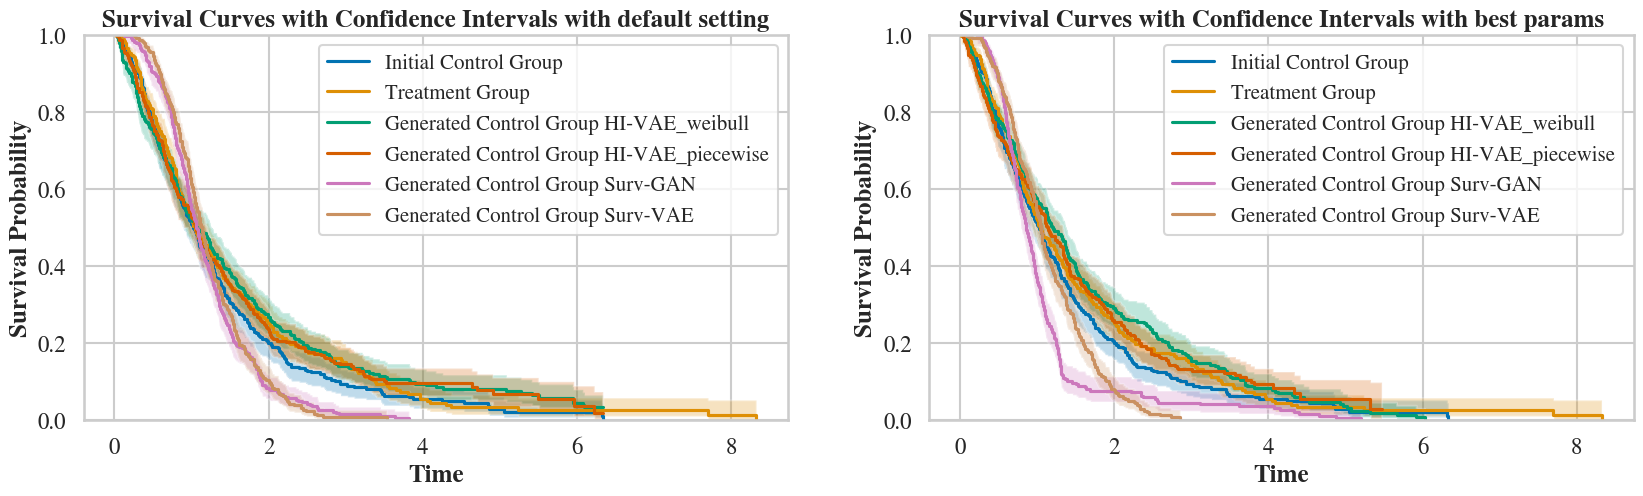

In [15]:
from sksurv.nonparametric import kaplan_meier_estimator

def kaplan_meier_estimation(surv_data, label=None, ax=None):
    surv_time  = surv_data['time'].values
    surv_ind = surv_data['censor'].values.astype(bool)
    uniq_time, surv_prob, conf_int = kaplan_meier_estimator(surv_ind, surv_time, conf_type="log-log")

    ax.step(uniq_time, surv_prob, where="post", label=label)
    ax.fill_between(uniq_time, conf_int[0], conf_int[1], alpha=0.25, step="post")

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
kaplan_meier_estimation(control, label="Initial Control Group", ax=axs[0])
kaplan_meier_estimation(treated, label="Treatment Group", ax=axs[0])

sel_dataset_idx = 0
for i, generator_name in enumerate(generators_sel):
    df_syn_sel = pd.DataFrame(data_gen_control_dict[generator_name][sel_dataset_idx].numpy(), columns=fnames)
    kaplan_meier_estimation(df_syn_sel, label="Generated Control Group " + generator_name, ax=axs[0])

axs[0].set_ylim(0, 1)
axs[0].legend(fontsize=15)
axs[0].set_xlabel("Time", fontweight="semibold")
axs[0].set_ylabel("Survival Probability", fontweight="semibold")
axs[0].set_title("Survival Curves with Confidence Intervals with default setting", fontweight="bold")

kaplan_meier_estimation(control, label="Initial Control Group", ax=axs[1])
kaplan_meier_estimation(treated, label="Treatment Group", ax=axs[1])

sel_dataset_idx = 0
for i, generator_name in enumerate(generators_sel):
    df_syn_sel = pd.DataFrame(data_gen_control_dict_best_params[generator_name][sel_dataset_idx].numpy(), columns=fnames)
    kaplan_meier_estimation(df_syn_sel, label="Generated Control Group " + generator_name, ax=axs[1])

axs[1].set_ylim(0, 1)
axs[1].legend(fontsize=15)
axs[1].set_xlabel("Time", fontweight="semibold")
axs[1].set_ylabel("Survival Probability", fontweight="semibold")
axs[1].set_title("Survival Curves with Confidence Intervals with best params", fontweight="bold")
plt.show()

In [16]:
# Convert generated data into dataframe
df_gen_control_dict = {}
df_syn_dict = {}
for generator_name in generators_sel:
    list_df_gen_control = []
    data_syn = []
    for j in range(n_generated_dataset):
        df_gen_control_j = pd.DataFrame(data_gen_control_dict_best_params[generator_name][j].numpy(), columns=fnames)
        df_gen_control_j['treatment'] = 0
        list_df_gen_control.append(df_gen_control_j)
        data_syn.append(pd.concat([df_init_treated, df_gen_control_j], ignore_index=True))
        
    df_gen_control_dict[generator_name] = list_df_gen_control
    df_syn_dict[generator_name] = data_syn

### 3. Compare generation performance

#### 3.1. General metrics

In [17]:
from utils.metrics import general_metrics
general_scores = []
for generator_name in generators_sel:
    general_scores.append(general_metrics(df_init_control, df_gen_control_dict[generator_name], generator_name))
general_scores_df = pd.concat(general_scores)

##### 3.1.1. Data resemblance

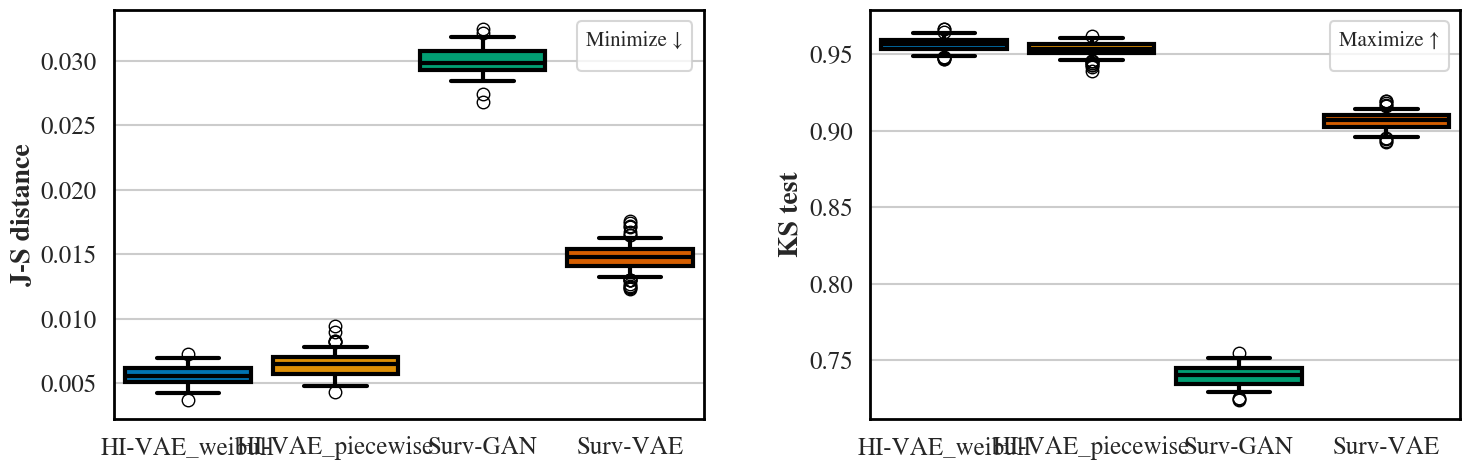

In [18]:
from utils.visualization import visualize_general_perf
visualize_general_perf(general_scores_df, metrics=[['J-S distance', "min"], ['KS test', "max"]])

##### 3.1.2. Utility

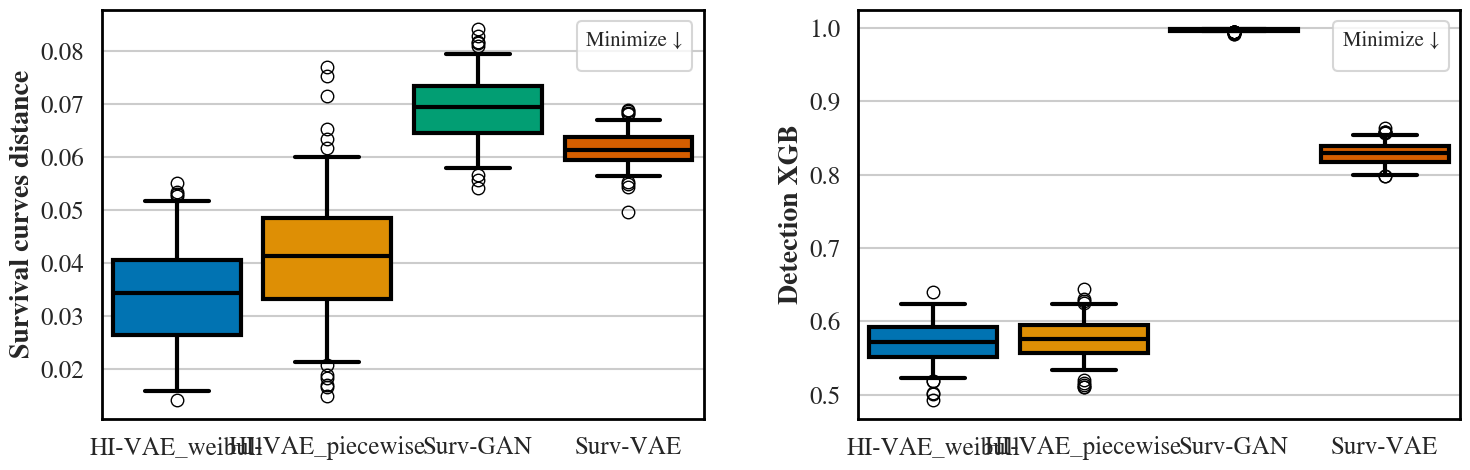

In [19]:
visualize_general_perf(general_scores_df, metrics=[['Survival curves distance', "min"], ['Detection XGB', "min"]])

#### 3.1.3. Privacy

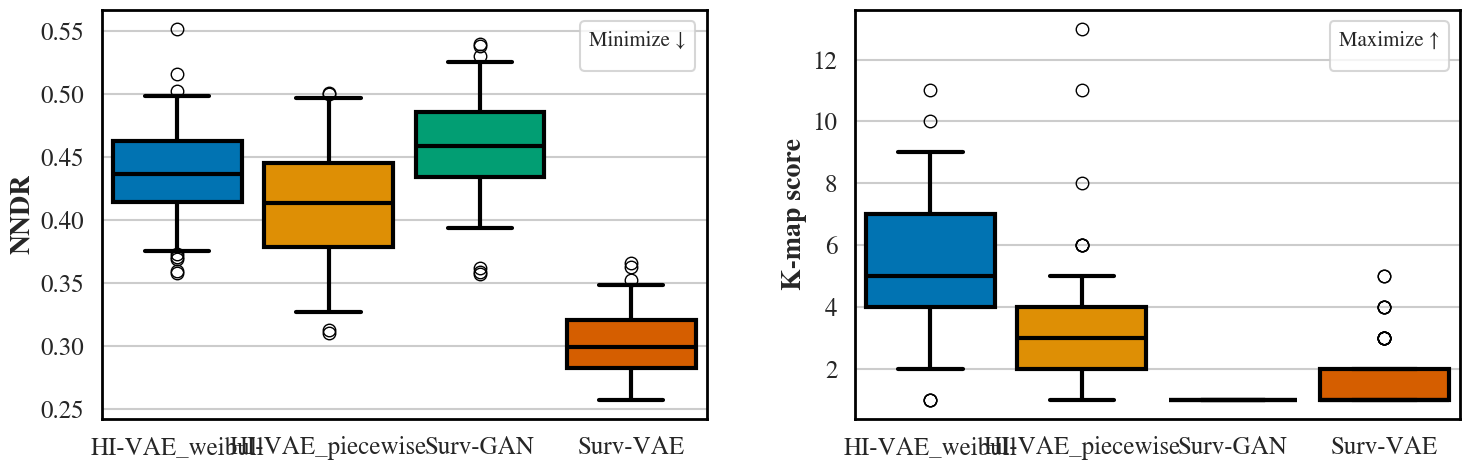

In [20]:
visualize_general_perf(general_scores_df, metrics=[['NNDR', "min"], ['K-map score', "max"]])

#### Replicability metrics

In [21]:
from utils.metrics import replicability_ext
replicability_scores = []
for generator_name in generators_sel:
    replicability_scores.append(replicability_ext(df_init, df_syn_dict[generator_name], generator_name))
replicability_scores_df = pd.concat(replicability_scores, ignore_index=True)

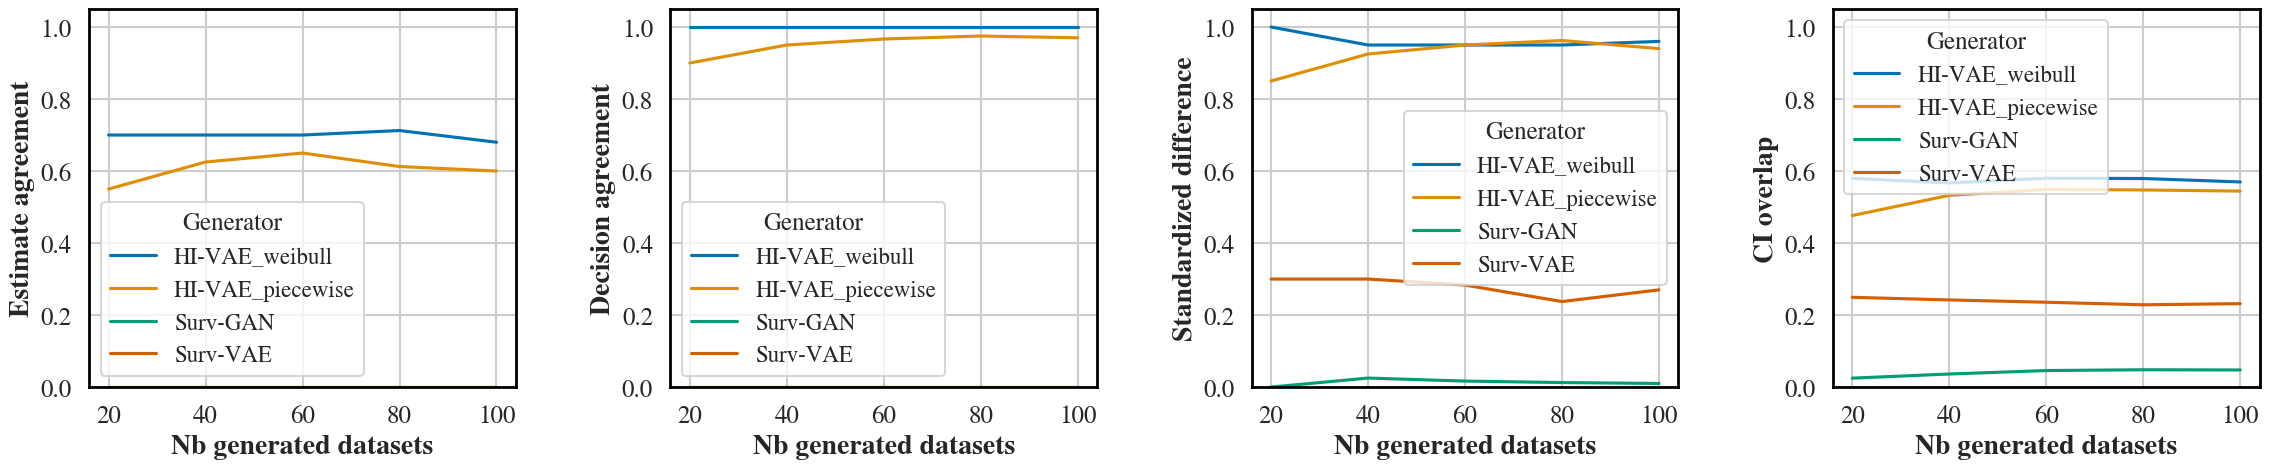

In [22]:
from utils.visualization import visualize_replicability_perf
visualize_replicability_perf(replicability_scores_df)

In [23]:
from utils.metrics import fit_cox_model
import numpy as np
columns = ['time', 'censor', 'treatment']
coef_init, _, ci_init, se_init = fit_cox_model(df_init, columns)
# Compute midpoints and widths
midpoints = [(ci_init[1] + ci_init[0]) / 2]
errors = [(ci_init[1] - ci_init[0]) / 2]
label = ["Init"]
colors = ['green', 'blue', 'orange', 'cyan']

colors_ = ['red']
for i , generator in enumerate(generators_sel):
    data_syn_ = df_syn_dict[generator]
    results = [fit_cox_model(data, columns) for data in data_syn_]
    coef_syn, _, _, se_syn = zip(*results)
    for n in range(10):
        coef_syn_, se_syn_ = np.array(coef_syn)[n][0], np.array(se_syn)[n][0]
        ci_syn = (coef_syn_ - 1.96 * se_syn_, coef_syn_ + 1.96 * se_syn_)
        midpoints.append((ci_syn[1] + ci_syn[0]) / 2)
        errors.append((ci_syn[1] - ci_syn[0]) / 2)
        label.append(generator + " " + str(n + 1))
        colors_.append(colors[i])

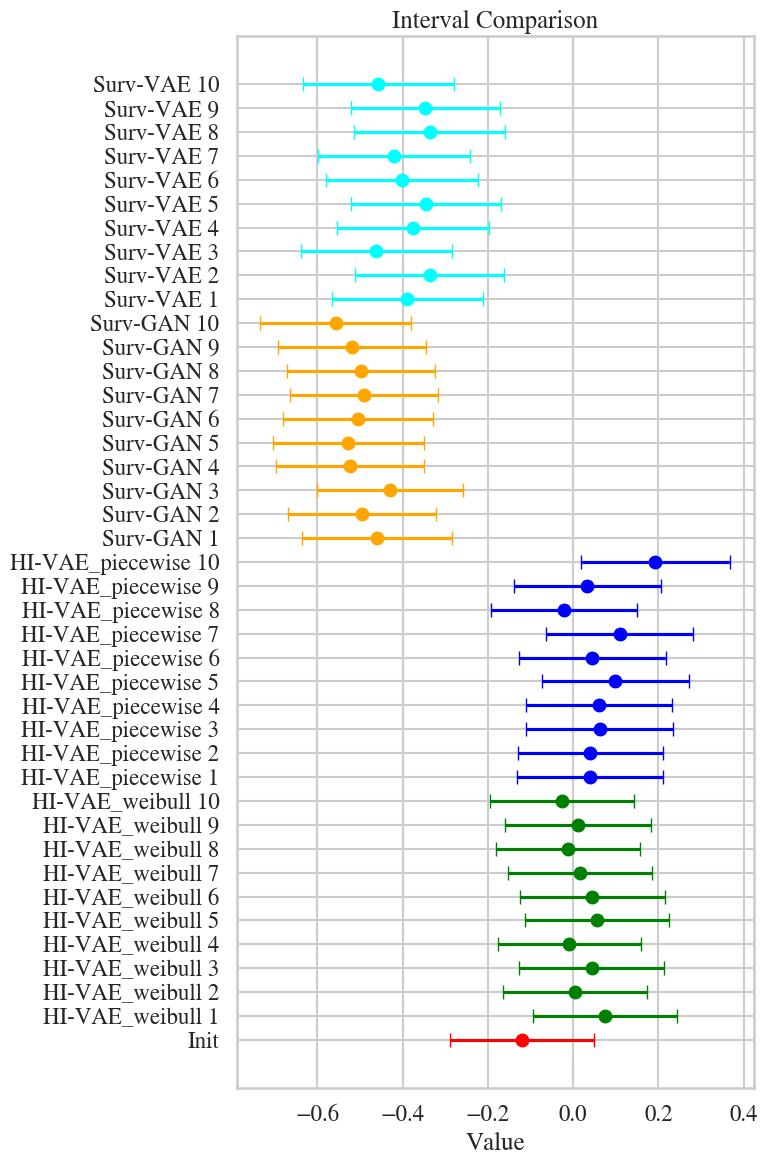

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 12))

# Plot as horizontal error bars
for i, (mid, err) in enumerate(zip(midpoints, errors)):
    ax.errorbar(x=mid, y=i, xerr=err, fmt='o', capsize=5, color=colors_[i])

plt.yticks(range(len(midpoints)), label)
plt.xlabel("Value")
plt.title("Interval Comparison")
plt.grid(True)
plt.tight_layout()
plt.show()